# Memory Failure Prediction Competition: Starter Kit

## This notebook is designed as a starter kit for the memory failure prediction competition. It includes steps for data processing, feature extraction, and model training using XGBoost.

In [1]:
# Install required packages
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [360]:
# Import necessary libraries
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pyarrow import feather
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [361]:
# Load ticket data
ticket = pd.read_csv('../sample_data/ticket.csv')

In [362]:
# Display the ticket data
ticket.head()

,sn_name,alarm_time,sn_type
0,sn_4191,1704077850,A
1,sn_10692,1704140121,A
2,sn_7219,1704148156,A
3,sn_31281,1704151660,A
4,sn_8854,1704159849,A


In [391]:
# Load and process training data for Server Type A
trainset_A_path = '../sample_data/server_type_A/'
trainset_A = []

for filename in os.listdir(trainset_A_path):
    file_path = os.path.join(trainset_A_path, filename)
    if filename.endswith('.feather'):  # Check for Feather files
        df = pd.read_feather(file_path)  # Use pandas.read_feather()
        df['sn'] = os.path.splitext(filename)[0]  # Extract filename without extension
        trainset_A.append(df)

trainset_A_df = pd.concat(trainset_A, ignore_index=True)

In [392]:
# Label the data based on anomalies
trainset_A_df['anomaly'] = 0
trainset_A_df.loc[trainset_A_df['sn'].isin(ticket['sn_name']), 'anomaly'] = 1

## Feature Engineering

### Error Counts Features

In [394]:
# Function to calculate error counts within specific time windows
def calculate_counts_features(df):
    df['LogTime'] = pd.to_datetime(df['LogTime'], unit='s')
    df = df.sort_values('LogTime')

    df['error_count_CE.READ_24h'] = 0
    df['error_count_CE.READ_1m'] = 0
    df['error_count_CE.SCRUB_24h'] = 0
    df['error_count_CE.SCRUB_1m'] = 0
    
    for index, row in df.iterrows():
        start_time_24h = row['LogTime'] - pd.Timedelta(hours=24)
        start_time_1m = row['LogTime'] - pd.Timedelta(minutes=1)
        end_time = row['LogTime']

        mask_24h = (df['LogTime'] >= start_time_24h) & (df['LogTime'] <= end_time)
        mask_1m = (df['LogTime'] >= start_time_1m) & (df['LogTime'] <= end_time)

        recent_data_24h = df.loc[mask_24h]
        recent_data_1m = df.loc[mask_1m]

        df.at[index, 'error_count_CE.READ_24h'] = recent_data_24h['error_type_full_name'].value_counts().get('CE.READ', 0)
        df.at[index, 'error_count_CE.READ_1m'] = recent_data_1m['error_type_full_name'].value_counts().get('CE.READ', 0)
        df.at[index, 'error_count_CE.SCRUB_24h'] = recent_data_24h['error_type_full_name'].value_counts().get('CE.SCRUB', 0)
        df.at[index, 'error_count_CE.SCRUB_1m'] = recent_data_1m['error_type_full_name'].value_counts().get('CE.SCRUB', 0)
        
    return df

processed_data_count = pd.concat([calculate_counts_features(group) for name, group in trainset_A_df.groupby('sn')])

### Fault Features

In [395]:
# Function to calculate fault features based on memory cell locations
def calculate_faults_features(df):
    df['LogTime'] = pd.to_datetime(df['LogTime'], unit='s')
    df['address'] = df['CpuId'].astype(str) + '-' + df['ChannelId'].astype(str) + '-' + df['RankId'].astype(str) + '-' + \
                    df['deviceID'].astype(str) + '-' + df['BankgroupId'].astype(str) + '-' + df['BankId'].astype(str) + '-' + \
                    df['ColumnId'].astype(str) + '-' + df['RowId'].astype(str)
    df['bank_column_key'] = df['CpuId'].astype(str) + '-' + df['ChannelId'].astype(str) + '-' + df['RankId'].astype(str) + '-' + \
                            df['deviceID'].astype(str) + '-' + df['BankgroupId'].astype(str) + '-' + df['BankId'].astype(str) + '-' + df['ColumnId'].astype(str)
    df['bank_row_key'] = df['CpuId'].astype(str) + '-' + df['ChannelId'].astype(str) + '-' + df['RankId'].astype(str) + '-' + \
                         df['deviceID'].astype(str) + '-' + df['BankgroupId'].astype(str) + '-' + df['BankId'].astype(str) + '-' + df['RowId'].astype(str)
    df['bank_key'] = df['CpuId'].astype(str) + '-' + df['ChannelId'].astype(str) + '-' + df['RankId'].astype(str) + '-' + \
                     df['deviceID'].astype(str) + '-' + df['BankgroupId'].astype(str) + '-' + df['BankId'].astype(str)
    
    df = df.sort_values('LogTime')
    df['cell_fault'] = 0
    df['column_fault'] = 0
    df['row_fault'] = 0
    df['bank_fault'] = 0
    
    for index, row in df.iterrows():
        faulty_banks = set()
        start_time = row['LogTime'] - pd.Timedelta(hours=24)
        end_time = row['LogTime']
        
        mask = (df['LogTime'] >= start_time) & (df['LogTime'] <= end_time)
        recent_data = df.loc[mask]
        
        address_counts = recent_data['address'].value_counts()
        df.at[index, 'cell_fault'] = len(address_counts[address_counts > 1])
        
        rowid_groups = recent_data.groupby('bank_column_key')['RowId'].nunique()
        df.at[index, 'column_fault'] = len(rowid_groups[rowid_groups > 1])
        
        columnid_groups = recent_data.groupby('bank_row_key')['ColumnId'].nunique()
        df.at[index, 'row_fault'] = len(columnid_groups[columnid_groups > 1])
        
        bank_groups = recent_data.groupby('bank_key')
        for bank_key, group in bank_groups:
            same_bank_rowid_groups = group.groupby('bank_column_key')['RowId'].nunique()
            same_bank_columnid_groups = group.groupby('bank_row_key')['ColumnId'].nunique()
            
            if len(same_bank_columnid_groups[same_bank_columnid_groups > 1]) > 1 and len(same_bank_rowid_groups[same_bank_rowid_groups > 1]) > 1:
                faulty_banks.add(bank_key)
        
        df.at[index, 'bank_fault'] = len(faulty_banks)
    return df

processed_data = pd.concat([calculate_faults_features(group) for name, group in trainset_A_df.groupby('sn')])

### Bit-Level Features

In [396]:
# Function to extract bit-level information from a bit mask
def _extract_beat_info(bit_mask: int):
    DQ_MAP = {'0': [], '1': [0], '2': [1], '3': [0, 1], '4': [2], '5': [0, 2], '6': [1, 2], '7': [0, 1, 2], '8': [3],
              '9': [0, 3], 'a': [1, 3], 'b': [0, 1, 3], 'c': [2, 3], 'd': [0, 2, 3], 'e': [1, 2, 3], 'f': [0, 1, 2, 3]}
    DEVICE_BURST = 8
    beat_info = {}
    X4_BIT_WIDTH = 4
    beat_info_tmp = format(int(bit_mask), "0%dx" % DEVICE_BURST)

    for beat in range(DEVICE_BURST):
        beat_info[str(beat)] = [beat_position for beat_position in DQ_MAP.get(beat_info_tmp[-(beat + 1)])]
    return beat_info

# Apply bit-level feature extraction
trainset_A_df["beat_info"] = trainset_A_df["RetryRdErrLogParity"].apply(_extract_beat_info)
trainset_A_df["total_err_bits"] = trainset_A_df["beat_info"].apply(lambda x: sum(len(b) for b in x.values()))

In [397]:
# Function to calculate the maximum error beat interval
def _max_err_beat_interval(beat_info):
    err_beat = [int(k) for k, b in beat_info.items() if len(b) > 0]
    if err_beat:
        return err_beat[-1] - err_beat[0]
    return 0

trainset_A_df["Max_err_beat_interval"] = trainset_A_df["beat_info"].apply(_max_err_beat_interval)

In [398]:
# Function to count the number of unique DQ errors
def err_dq_count(beat_info):
    unique_err_dq = set()
    for b in beat_info.values():
        unique_err_dq.update(b)
    return len(unique_err_dq)

trainset_A_df["err_dq_count"] = trainset_A_df["beat_info"].apply(err_dq_count)

### Combine Features for Modeling

In [399]:
# Combine extracted features
extract_bit_features = trainset_A_df[["total_err_bits", 'err_dq_count', "Max_err_beat_interval"]]
extract_fault_features = processed_data[['cell_fault', 'row_fault', 'column_fault', 'bank_fault']]
extract_count_features = processed_data_count[[ 'error_count_CE.READ_24h', 'error_count_CE.READ_1m',
                                                'error_count_CE.SCRUB_24h', 'error_count_CE.SCRUB_1m']]

features = pd.concat([extract_count_features, extract_fault_features, extract_bit_features], axis=1)

In [400]:
# Define feature matrix (X) and target vector (y)
X = features
y = trainset_A_df['anomaly']

In [401]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Model Training with XGBoost

In [402]:
# Prepare data for XGBoost
dtrain_xgb = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest_xgb = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# XGBoost model parameters
params_xgb = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'eval_metric': 'logloss',
    'random_state': 42
}

# Custom callback for progress bar
class XGBoostProgressCallback(xgb.callback.TrainingCallback):
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="XGBoost Training Progress")

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        if epoch + 1 == self.pbar.total:
            self.pbar.close()
        return False

# Train the model with progress bar
num_boost_round = 100
evals_result_xgb = {}
bst_xgb = xgb.train(params_xgb, dtrain_xgb, num_boost_round=num_boost_round, evals=[(dtest_xgb, 'test')],
                    evals_result=evals_result_xgb, callbacks=[XGBoostProgressCallback(num_boost_round)])

XGBoost Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

[0]	test-logloss:0.12388
[1]	test-logloss:0.09089
[2]	test-logloss:0.06813
[3]	test-logloss:0.05202
[4]	test-logloss:0.04065
[5]	test-logloss:0.03249
[6]	test-logloss:0.02664
[7]	test-logloss:0.02228
[8]	test-logloss:0.01899
[9]	test-logloss:0.01657
[10]	test-logloss:0.01484
[11]	test-logloss:0.01389
[12]	test-logloss:0.01325
[13]	test-logloss:0.01266
[14]	test-logloss:0.01224
[15]	test-logloss:0.01209
[16]	test-logloss:0.01196
[17]	test-logloss:0.01176
[18]	test-logloss:0.01183
[19]	test-logloss:0.01190
[20]	test-logloss:0.01193
[21]	test-logloss:0.01187
[22]	test-logloss:0.01183
[23]	test-logloss:0.01199
[24]	test-logloss:0.01209
[25]	test-logloss:0.01219
[26]	test-logloss:0.01209
[27]	test-logloss:0.01216
[28]	test-logloss:0.01208
[29]	test-logloss:0.01202
[30]	test-logloss:0.01217
[31]	test-logloss:0.01230
[32]	test-logloss:0.01241
[33]	test-logloss:0.01248
[34]	test-logloss:0.01256
[35]	test-logloss:0.01251
[36]	test-logloss:0.01258
[37]	test-logloss:0.01265
[38]	test-logloss:0.01

XGBoost Training Progress:  83%|████████▎ | 83/100 [00:00<00:00, 825.79it/s]

[83]	test-logloss:0.01244
[84]	test-logloss:0.01250
[85]	test-logloss:0.01247
[86]	test-logloss:0.01246
[87]	test-logloss:0.01244
[88]	test-logloss:0.01243
[89]	test-logloss:0.01248
[90]	test-logloss:0.01246
[91]	test-logloss:0.01244
[92]	test-logloss:0.01249
[93]	test-logloss:0.01248
[94]	test-logloss:0.01246
[95]	test-logloss:0.01246
[96]	test-logloss:0.01251
[97]	test-logloss:0.01248
[98]	test-logloss:0.01247
[99]	test-logloss:0.01251


XGBoost Training Progress: 100%|██████████| 100/100 [00:00<00:00, 829.81it/s]


In [403]:
# Model evaluation
y_pred_xgb = bst_xgb.predict(dtest_xgb)
y_pred_xgb_binary = [1 if y > 0.5 else 0 for y in y_pred_xgb]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb_binary)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb_binary)
class_report_xgb = classification_report(y_test, y_pred_xgb_binary)

print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Confusion Matrix:")
print(conf_matrix_xgb)
print("XGBoost Classification Report:")
print(class_report_xgb)

XGBoost Accuracy: 0.998019801980198
XGBoost Confusion Matrix:
[[972   0]
 [  2  36]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       972
           1       1.00      0.95      0.97        38

    accuracy                           1.00      1010
   macro avg       1.00      0.97      0.99      1010
weighted avg       1.00      1.00      1.00      1010



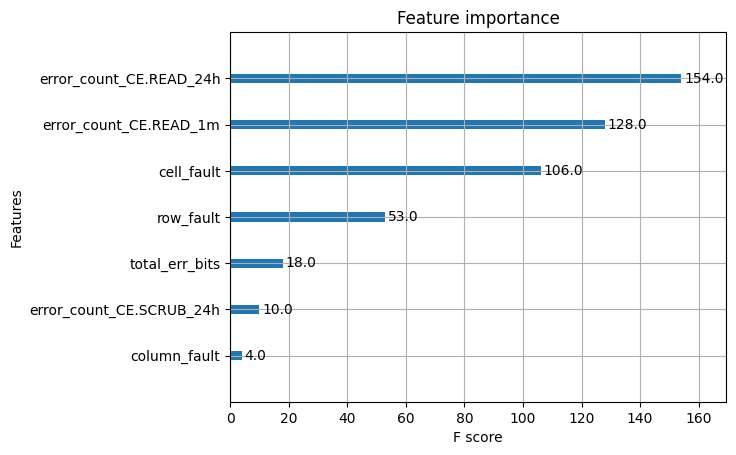

In [404]:
# Plot feature importances for XGBoost
xgb.plot_importance(bst_xgb)
plt.show()